<a href="https://colab.research.google.com/github/RickyF404/Tesi/blob/main/AEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

# Conditional Variational AutoEncoder (CVAE)

In [2]:
df_temp = pd.read_csv("/content/drive/MyDrive/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [3]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
class CVAE(keras.Model):
  def __init__(self, input_dim, cond_dim = 1, latent_dim = 2, beta = 0.001, **kwargs):
    super(CVAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    cond_input = keras.Input(shape=(cond_dim,))
    x = layers.Concatenate()([x_input, cond_input])
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model([x_input, cond_input], [z_mean, z_log_var, z], name="encoder")

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    cond_inputs_dec = keras.Input(shape=(cond_dim,))
    x = layers.Concatenate()([latent_inputs, cond_inputs_dec])
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    self.decoder = keras.Model([latent_inputs, cond_inputs_dec], outputs, name="decoder")

  def train_step(self, data):
    (x, cond), y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder([x, cond], training = True)
      reconstruction = self.decoder([z, cond], training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    x, cond = inputs
    z_mean, _,  z = self.encoder([x, cond])
    return self.decoder([z, cond])


In [5]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

2 mesi di dati reali

In [6]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 2
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.015796
1   [2024-02, 2024-03]            2      0.018242
2   [2024-03, 2024-04]            2      0.018981
3   [2024-04, 2024-05]            2      0.015335
4   [2024-05, 2024-06]            2      0.015871
5   [2024-06, 2024-07]            2      0.013325
6   [2024-07, 2024-08]            2      0.013728
7   [2024-08, 2024-09]            2      0.014832
8   [2024-09, 2024-10]            2      0.016637
9   [2024-10, 2024-11]            2      0.017151

4 mesi di dati reali

In [7]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 4
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.016014
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.014859
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.018022
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.017902
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.015906
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.011731
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.016062
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.018427
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 6
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.017770  
1      0.021400  
2      0.016863  
3      0.016034  
4      0.017417  
5      0.018401  
6      0.016074  


2 mesi di dati falsi

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            2  0.013517


4 mesi di dati falsi

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            4  0.015595


6 mesi di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            6  0.017973


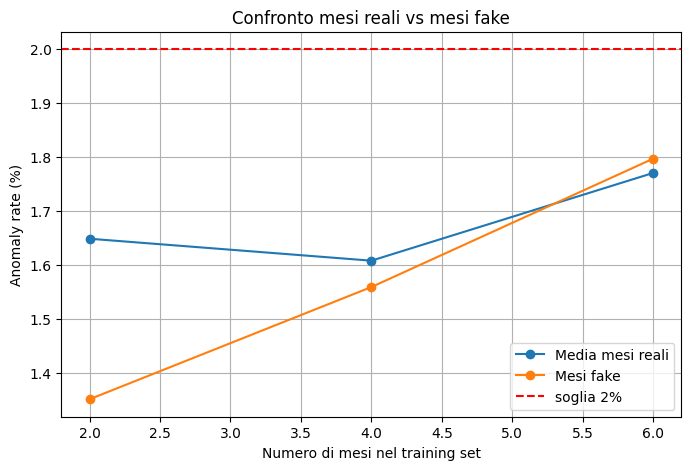

In [12]:
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

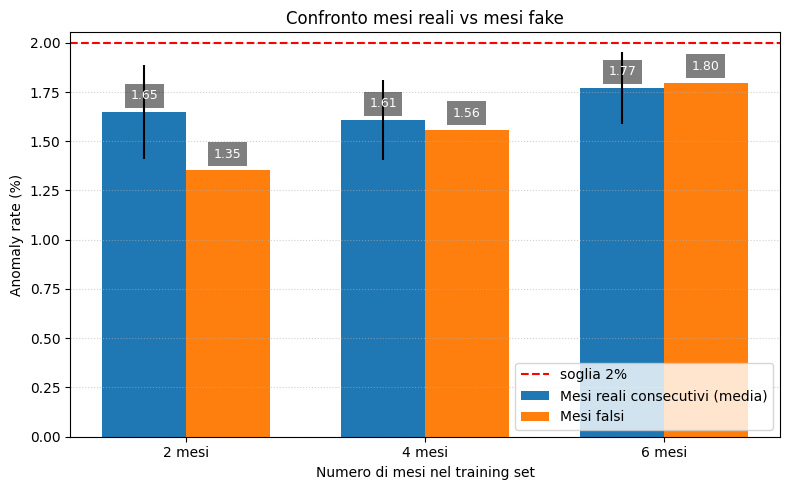

In [13]:
labels = ["2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Variational AutoEncoder (VAE) senza temperatura

In [38]:
df_original = pd.read_csv("/content/drive/MyDrive/data_no_temperature.csv", encoding = "utf-8")
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original["timestamp"] = df_original["timestamp"].dt.tz_localize(None)
df_original = df_original.sort_values("timestamp")

end = "2025-01-01"
df = df_original[(df_original["timestamp"] < end)]

In [39]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [40]:
class VAE(keras.Model):
  def __init__(self, input_dim, latent_dim = 2, beta = 0.001, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    x = layers.Dense(32, activation="relu")(x_input)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model(x_input, [z_mean, z_log_var, z])

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    self.decoder = keras.Model(latent_inputs, outputs)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x, training = True)
      reconstruction = self.decoder(z, training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    z_mean, _,  z = self.encoder(inputs)
    return self.decoder(z)


In [41]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

2 mesi di dati reali

In [42]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.012739
1   [2024-02, 2024-03]            2      0.012034
2   [2024-03, 2024-04]            2      0.014013
3   [2024-04, 2024-05]            2      0.022748
4   [2024-05, 2024-06]            2      0.019711
5   [2024-06, 2024-07]            2      0.014721
6   [2024-07, 2024-08]            2      0.015635
7   [2024-08, 2024-09]            2      0.014320
8   [2024-09, 2024-10]            2      0.013053
9   [2024-10, 2024-11]            2      0.015743

4 mesi di dati reali

In [43]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.017917
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.021182
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.018022
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.018219
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.015270
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.013792
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.015585
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.014901
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [44]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.019251  
1      0.019738  
2      0.016442  
3      0.015612  
4      0.020178  
5      0.014382  
6      0.017788  


2 mesi di dati falsi

In [45]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            2  0.019321


4 mesi di dati falsi

In [46]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.017812


6 mesi di dati falsi

In [47]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            6  0.020683


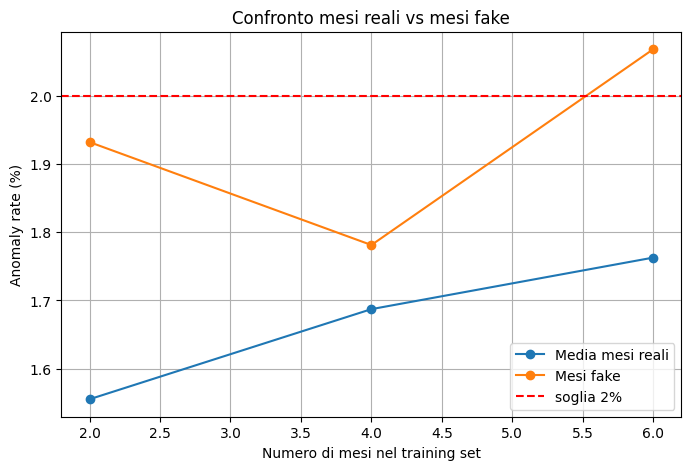

In [48]:
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

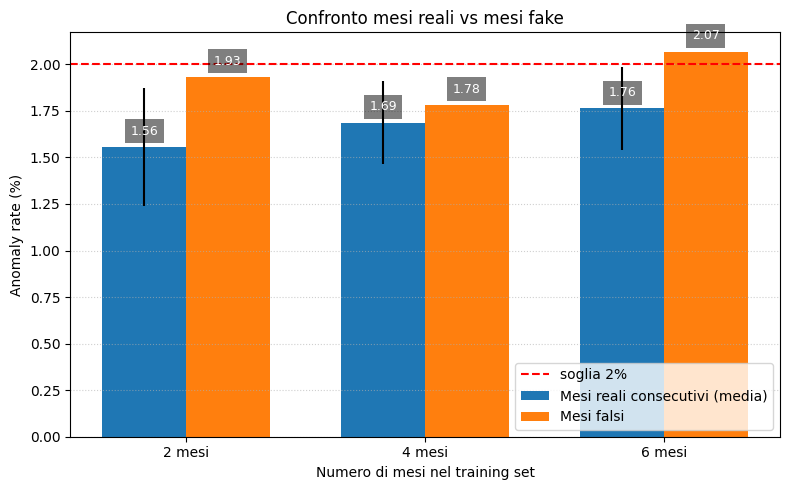

In [49]:
labels = ["2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Variational AutoEncoder (VAE) con temperatura

In [50]:
df_temp = pd.read_csv("/content/drive/MyDrive/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
df = df_temp[(df_temp["timestamp"] < end)]

In [51]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [52]:
class VAE(keras.Model):
  def __init__(self, input_dim, output_dim, latent_dim = 4, beta = 0.001, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    x = layers.Dense(32, activation="relu")(x_input)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model(x_input, [z_mean, z_log_var, z])

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(output_dim, activation="linear")(x)

    self.decoder = keras.Model(latent_inputs, outputs)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x, training = True)
      reconstruction = self.decoder(z, training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x[:, :6] - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    z_mean, _,  z = self.encoder(inputs)
    return self.decoder(z)


In [53]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

2 mesi di dati reali

In [54]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


KeyboardInterrupt: 

4 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

6 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

2 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

4 mesi di dati falsi

In [ ]:
# parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

6 mesi di dati falsi

In [ ]:
# parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

In [ ]:
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
labels = ["2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# AutoEncoder (AE) senza temperatura

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [ ]:
df_original = pd.read_csv("/content/drive/MyDrive/data_no_temperature.csv", encoding = "utf-8")
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original["timestamp"] = df_original["timestamp"].dt.tz_localize(None)
df_original = df_original.sort_values("timestamp")

end = "2025-01-01"
df = df_original[(df_original["timestamp"] < end)]

In [ ]:
def build_ae(input_dim, latent_dim=4):
  #encoder
  input_enc = layers.Input(shape=(input_dim,))
  x = layers.Dense(32, activation="relu")(input_enc)
  x = layers.Dense(16, activation="relu")(x)
  z = layers.Dense(latent_dim, activation="relu", name="latent")(x)

  #decoder
  x = layers.Dense(16, activation="relu")(z)
  x = layers.Dense(32, activation="relu")(x)
  output_dec = layers.Dense(input_dim, activation="linear")(x)

  #autoencoder
  ae = keras.Model(input_enc, output_dec, name="autoencoder")
  ae.compile(optimizer="adam", loss="mse")
  return ae

In [ ]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

2 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=4)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

4 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=4)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

6 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=4)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

2 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

4 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

6 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

In [ ]:
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
labels = ["2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# AutoEncoder (AE) con temperatura

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [ ]:
df_temp = pd.read_csv("/content/drive/MyDrive/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
df = df_temp[(df_temp["timestamp"] < end)]

In [ ]:
def build_ae_temp(input_dim = 7, output_dim = 6, latent_dim=4):
  #encoder
  input_enc = layers.Input(shape=(input_dim,))
  x = layers.Dense(32, activation="relu")(input_enc)
  x = layers.Dense(16, activation="relu")(x)
  z = layers.Dense(latent_dim, activation="relu", name="latent")(x)

  #decoder
  x = layers.Dense(16, activation="relu")(z)
  x = layers.Dense(32, activation="relu")(x)
  output_dec = layers.Dense(output_dim, activation="linear")(x)

  #autoencoder
  ae = keras.Model(input_enc, output_dec, name="autoencoder")
  ae.compile(optimizer="adam", loss="mse")
  return ae

In [ ]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

2 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=4)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

4 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=4)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

6 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=4)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

2 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=4)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

4 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=4)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

6 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=4)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

In [ ]:
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
labels = ["2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Deep Support Vector Data Description (SVDD)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [ ]:
df_original = pd.read_csv("/content/drive/MyDrive/data_no_temperature.csv", encoding = "utf-8")
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original["timestamp"] = df_original["timestamp"].dt.tz_localize(None)
df_original = df_original.sort_values("timestamp")

end = "2025-01-01"
df = df_original[(df_original["timestamp"] < end)]

In [ ]:
def build_svdd_model(input_dim, latent_dim=8):
  inputs = layers.Input(shape=(input_dim,))
  x = layers.Dense(32, activation="relu")(inputs)
  x = layers.Dense(16, activation="relu")(x)
  latent = layers.Dense(latent_dim, activation=None)(x)
  model = models.Model(inputs, latent, name="DeepSVDD")
  return model

def compute_center(model, X):
  Z = model.predict(X, verbose=0)
  c = np.mean(Z, axis=0)
  return tf.constant(c, dtype=tf.float32)

@tf.function
def svdd_loss(model, x, c, nu=0.1):
  z = model(x, training=True)
  dist = tf.reduce_sum(tf.square(z - c), axis=1)
  loss = tf.reduce_mean(dist)
  return loss, dist

def train_svdd(model, X_train, epochs=50, batch_size=64, lr=1e-4):
  c = compute_center(model, X_train)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      loss, _ = svdd_loss(model, tf.constant(X_train, dtype=tf.float32), c)
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} - Loss: {loss.numpy():.4f}")
        return c

In [ ]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

2 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=8)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

4 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=8)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

6 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=8)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

2 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=8)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

4 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=8)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

6 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=8)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

In [ ]:
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
labels = ["2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()